# Eindhoven University of Technology, Netherlands.
## Mathematics & Computer Science
## Data Science Master track
## Recommender Systems
Lecturer: Dr. Vlado Menkovski
- Franziska Boenisch
- Adriano Cardace 
- Camilo Montenegro Hernandez

## Image Caption Generation

## Task 2.1: Encoder Decoder Model

Build an image caption generator model, as described in Vinyals, Oriol, et al. "Show and tell: A neural image caption generator." Proceedings of the IEEE conference on computer vision and pattern recognition. 2015. The model shall consist of:

- Image encoder (image feature extractor)
- Caption generator (RNN-based)



In [ ]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential, load_model
from keras.layers import LSTM, GRU, Embedding, TimeDistributed, Dense, RepeatVector, Add, Lambda,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/My Drive/assignment3

/content/drive/My Drive/assignment3


In [ ]:
!pip install pydrive

In [ ]:
# authenticate Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# import the given classes for preprocessing to Colab
data_connector = drive.CreateFile({'id':'10zoNdeEd8TiDgEgD9FchzZr8An9QIp87'})
data_connector.GetContentFile('data_connector.py')

data_iterator = drive.CreateFile({'id':'1176aavMjeOnt_aIcbZv4GCtnL947GZoo'})
data_iterator.GetContentFile('data_iterator.py')

beam_search = drive.CreateFile({'id':'141H_Hhd6cbxQpMxRzueKsEPmYzMqwRh9'})
beam_search.GetContentFile('beam_search.py')


from data_connector import DataConnector
from data_iterator import Dataiterator
from beam_search import Hypothesis, decode_one_step, run_beam_search, sort_hyps

In [ ]:
# load the data we need
filepath = "/content/drive/My Drive/assignment3/data/"
#data_reader = DataConnector(filepath, filename)

description_path = filepath+"descriptions.pkl"
f = open(description_path, 'rb')
descriptions = load(f)

dev_description_path = filepath+"dev_descriptions.pkl"
f = open(dev_description_path, 'rb')
dev_descriptions = load(f)

test_description_path = filepath+"test_descriptions.pkl"
f = open(test_description_path, 'rb')
test_descriptions = load(f)

train_description_path = filepath+"train_descriptions.pkl"
f = open(train_description_path, 'rb')
train_descriptions = load(f)

# encoding
# encoding_train['3141613533_595723208d.jpg'].shape --> (2048,) 
# this makes me think that it is the image encoding?
encoding_dev_path = filepath+"encoding_dev.pkl"
f = open(encoding_dev_path, 'rb')
encoding_dev = load(f)

encoding_test_path = filepath+"encoding_test.pkl"
f = open(encoding_test_path, 'rb')
encoding_test = load(f)

encoding_train_path = filepath+"encoding_train.pkl"
f = open(encoding_train_path, 'rb')
encoding_train = load(f)

# index to word: dictionary mapping the index to the word it stands for
# -> 14: endseq and 1: startseq
ixtoword_path = filepath+"ixtoword.pkl"
f = open(ixtoword_path, 'rb')
ixtoword = load(f)

wordtoix_path = filepath+"wordtoix.pkl"
f = open(wordtoix_path, 'rb')
wordtoix = load(f)


# (5000, 34) -> 5000 for testing (5 captions per 1000 images)
# 34 sentence max length
test_cap_in_path = filepath+"test_cap_in.npy"
f = open(test_cap_in_path, 'rb')
test_cap_in = np.load(f)

test_cap_out_path = filepath+"test_cap_out.npy"
f = open(test_cap_out_path, 'rb')
test_cap_out = np.load(f)

# 30.000 for training
train_cap_in_path = filepath+"train_cap_in.npy"
f = open(train_cap_in_path, 'rb')
train_cap_in = np.load(f)

train_cap_out_path = filepath+"train_cap_out.npy"
f = open(train_cap_out_path, 'rb')
train_cap_out = np.load(f)

# dev
dev_cap_in_path = filepath+"dev_cap_in.npy"
f = open(dev_cap_in_path, 'rb')
dev_cap_in = np.load(f)

dev_cap_out_path = filepath+"dev_cap_out.npy"
f = open(dev_cap_out_path, 'rb')
dev_cap_out = np.load(f)

# now load the pictures
# as the last layer of the convnet
train_img_in_path = filepath+"train_img_in.npy"
f = open(train_img_in_path, 'rb')
train_img_in = np.load(f)

# shape: (5000, 2048)
test_img_in_path = filepath+"test_img_in.npy"
f = open(test_img_in_path, 'rb')
test_img_in = np.load(f)

# shape: (5000, 2048)
dev_img_in_path = filepath+"dev_img_in.npy"
f = open(dev_img_in_path, 'rb')
dev_img_in = np.load(f)

# embedding matrix
embedding_matrix_path = filepath+"embedding_matrix.npy"
f = open(embedding_matrix_path, 'rb')
embedding_matrix = np.load(f)

In [ ]:
descriptions['101654506_8eb26cfb60']

['brown and white dog is running through the snow',
 'dog is running in the snow',
 'dog running through snow',
 'white and brown dog is running through snow covered field',
 'the white and brown dog is running over the surface of the snow']

## Model

### Image Encoder

In [ ]:
n_features = 300 # assuming that output of cnn is 300
embedding_dim = 300# embedding_matrix.shape[1] # word embedding layer: 300
rnn_dim = 300 #according to the paper 512
batch_size = 1
n_timesteps = 34 # max length of sentences
dim_output = len(ixtoword)+1 # length of vocabulary --> 1651 +1 (to fit data iterator)
vocab_size = dim_output

In [ ]:
# image input 
image_in = Input(shape=(2048,), name='image_inputs')

In [ ]:
# image encoder
fe1 = Dropout(0.5, name='dropout_img_feats')(image_in)
image_dense = Dense(rnn_dim, activation='relu', name = 'dense_img_feats')
fe2 = image_dense(fe1) # reduce the dimension with FC projection
print(fe2.shape)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 300)


In [ ]:
encoder_model = Model(image_in, fe2)

### Caption Generator

In [ ]:
s0 = Input(shape=(rnn_dim,), name='s0')
s = [s0]

In [ ]:
# decoder model
decoder_inputs = Input(shape=(None,), name='decoder_inputs')
decoder_embedding = Embedding(dim_output, embedding_dim, weights = [embedding_matrix], name='embedding_decoder')
embedding_output = decoder_embedding(decoder_inputs)

s0 = Input(shape=(rnn_dim,), name='s0') 
s = [s0]
    
gru_decoder = GRU(rnn_dim, return_state=True)

decoder_dense = Dense(dim_output, activation='softmax')

probs = []
decoder_length = 34

for t in range(decoder_length):
#     print(t)
    x_dec = Lambda(lambda x: x[:,t,:], name='dec_embedding-%s'%t)(embedding_output)
    x_dec = Reshape((1, embedding_dim))(x_dec)

    if t==0:
        s = fe2
        
    s, next_state  = gru_decoder(x_dec, initial_state=s)

    prob = decoder_dense(s)
    probs.append(prob)
    
    s = [next_state]

### The model shall be constructed based on the following inputs

In [ ]:
# Construct the model
model = Model(inputs=[image_in, decoder_inputs, s0], outputs=probs) #TODO: is it s0 or encoder_states
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
embedding_decoder (Embedding)   (None, None, 300)    495600      decoder_inputs[0][0]             
__________________________________________________________________________________________________
image_inputs (InputLayer)       (None, 2048)         0                                            
__________________________________________________________________________________________________
dec_embedding-0 (Lambda)        (None, 300)          0           embedding_decoder[0][0]          
__________________________________________________________________________________________________
dropout_im

In [ ]:
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical

class Dataiterator():

    def __init__(self, img_in, cap_in, cap_out, vocab_size=1651, seq_length=34, decoder_dim=300, batch_size=4):
        
        self.img_in = img_in
        self.cap_in = cap_in 
        self.cap_out = cap_out
        self.states = np.zeros((len(img_in), decoder_dim)) 
        self.num_data = len(img_in) 
        self.vocab_size = vocab_size
        self.batch_size = batch_size 
        self.seq_length = seq_length
        self.reset() # initial: shuffling examples and set index to 0
        
    
    def onehotencoding(self, data):
                 
        return to_categorical(data, num_classes=self.vocab_size+1, dtype='int32')
    
    def __iter__(self): # iterates data
        
        return self


    def reset(self): # initials
        
        self.idx = 0
        self.order = np.random.permutation(self.num_data) # shuffling examples by providing randomized ids 
        
    def __next__(self): # return model inputs - outputs per batch
        
        X_ids = [] # hold ids per batch 

        while len(X_ids) < self.batch_size:

            X_id = self.order[self.idx] # copy random id from initial shuffling
            X_ids.append(X_id)

            self.idx += 1 # 
            if self.idx >= self.num_data: # exception if all examples of data have been seen (iterated)
                self.reset()
                raise StopIteration()
    
        batch_img_in = self.img_in[np.array(X_ids)] # X values (encoder input) per batch
        batch_cap_in = self.cap_in[np.array(X_ids)] # y_in values (decoder input) per batch
        batch_cap_out = self.cap_out[np.array(X_ids)]
        batch_states = self.states[np.array(X_ids)] # state values (decoder state input) per batch
        batch_y = self.onehotencoding(batch_cap_out)
        
     
        return batch_img_in, batch_cap_in, batch_states, list(batch_y.swapaxes(0,1))

    # return all data examples 
    def all(self):
      
        y = self.onehotencoding(self.cap_out)
        
        return self.img_in, self.cap_in, self.states, list(y.swapaxes(0,1))

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


steps = 30000 / 4 # number of datapoints per batch (30000 = 6000 pictures * 5 captions)
steps_val = 5000 / 4 #


def train_generator(model, batch_train_iter, batch_val_iter):
    
    earlystop_callbacks = [EarlyStopping(monitor='val_loss', patience=10),
                     ModelCheckpoint(filepath=os.path.join('./','{epoch:02d}-{loss:.2f}.check'), \
                                     monitor='val_loss', save_best_only=False, \
                                     save_weights_only=True)
                     ]
    
    def train_gen():
        while True:
          
            for  X, y_in, state, y_out in batch_train_iter:
              yield [[X, y_in, state], y_out]

                
    def val_gen():
        while True:
            val_batches = [[[X, y_in, state], y_out] for X, y_in, \
                           state, y_out in batch_val_iter]
            for val_batch in val_batches:
                yield val_batch
                
    history = model.fit_generator(train_gen(), validation_data=val_gen(), \
                                  validation_steps=steps_val, steps_per_epoch=steps, \
                                  epochs = 25, callbacks = earlystop_callbacks)

In [ ]:
# use the provided data iterator
data_iterator = Dataiterator(train_img_in, train_cap_in, train_cap_out)

dev_iterator = Dataiterator(dev_img_in, dev_cap_in, dev_cap_out)

### Training

In [ ]:
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [ ]:
# train the model here
train_generator(model, data_iterator, dev_iterator)

In [ ]:
# model.save_weights('model-new.check')

In [ ]:
model.load_weights('model-new.check')

## Task 2.2: Decoder Model

Based on the completed encoder-decoder, build a decoder model for generating captions using two approaches:
- Greedy search
- Beam search

In [ ]:
print(dev_img_in[0].shape)
codes = encoder_model.predict(np.expand_dims(dev_img_in[0], axis=0))
codes.shape

(2048,)


(1, 300)

In [ ]:
s0 = Input(shape=(rnn_dim,), name='s0') 
s = [s0]
in_decoder = Input(shape=(None, ), name='decoder_input')

in_dec_embedded =  decoder_embedding(in_decoder)
s, new_state = gru_decoder(in_dec_embedded, initial_state=s)
softmax_prob = decoder_dense(s)

decoder_model = Model([in_decoder] + [s0] , [softmax_prob] + [new_state])

### Greedy search

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    
    # to get the photo to the right dimension
    next_state = encoder_model.predict([photo])
    
    # index 1 equals to 'startseq'
    index = 1
    for i in range(34):
        yhat, next_state = decoder_model.predict([[index], next_state], verbose=0)
        
        index = np.argmax(yhat)
        word = ixtoword[index]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

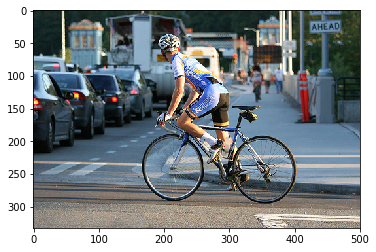

Greedy: man in blue and white outfit rides bike


In [ ]:
images = filepath + 'Flicker8k_Dataset/'

pic = list(encoding_train.keys())[1]
image = encoding_train[pic].reshape((1,2048))
# image = encoding_train[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

### Beam search

In [ ]:
def beam_search_predictions(image, beam_index = 1):
    start = [wordtoix["startseq"]]
    
    start_word = [[start, 0.0]]

    while len(start_word[0][0]) < 34:

        temp = []
        for s in start_word:
          
            sequence = s[0]
            next_state = encoder_model.predict([image])
            
            for word_index in sequence:
              preds, next_state = decoder_model.predict([[word_index], next_state], verbose=0)

            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]

    intermediate_caption = [ixtoword[i] for i in start_word if i!=0]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

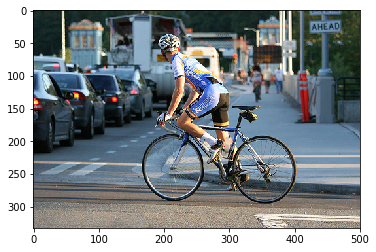

Beam Search, k=1: man in blue and white outfit rides bike
Beam Search, k=3: man on bicycle riding down the street


In [ ]:
pic = list(encoding_train.keys())[1]
image = encoding_train[pic].reshape((1,2048))
# image = encoding_train[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print('Beam Search, k=1:', beam_search_predictions(image, beam_index=1))
print('Beam Search, k=3:', beam_search_predictions(image, beam_index=3))

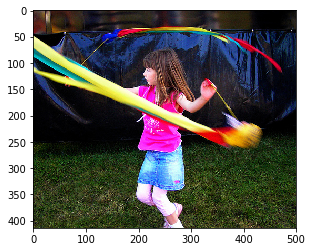

Beam Search, k=1: young girl wearing pink shirt and blue jeans is running through the grass
Beam Search, k=3: little girl in pink shirt and blue shorts is playing with hula hoops


In [ ]:
pic = list(encoding_train.keys())[6]
image = encoding_train[pic].reshape((1,2048))
# image = encoding_train[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print('Beam Search, k=1:', beam_search_predictions(image, beam_index=1))
print('Beam Search, k=3:', beam_search_predictions(image, beam_index=3))

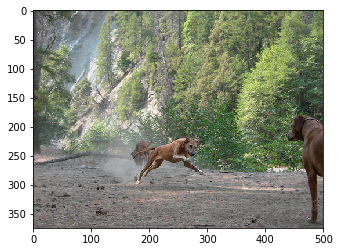

Beam Search, k=1: dog running in the sand
Beam Search, k=3: brown dog is running through the woods


In [ ]:
pic = list(encoding_train.keys())[8]
image = encoding_train[pic].reshape((1,2048))
# image = encoding_train[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print('Beam Search, k=1:', beam_search_predictions(image, beam_index=1))
print('Beam Search, k=3:', beam_search_predictions(image, beam_index=3))

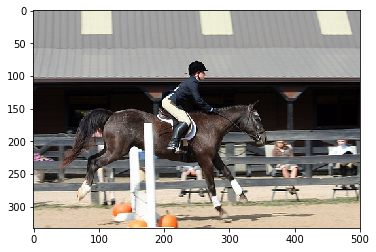

Beam Search, k=1: man in cowboy hat rides horse
Beam Search, k=3: horse and rider jump over fence


In [ ]:
pic = list(encoding_train.keys())[13]
image = encoding_train[pic].reshape((1,2048))
# image = encoding_train[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print('Beam Search, k=1:', beam_search_predictions(image, beam_index=1))
print('Beam Search, k=3:', beam_search_predictions(image, beam_index=3))